In [62]:
import numpy as np
from PIL import Image

In [63]:
projection_bin = "data/ball_view/short_throw_depth_camera_space_projection-1.bin"
image_height = 450
image_width = 448

In [12]:
projection = np.fromfile(projection_bin, dtype = np.float32)
print(projection.shape)

(403200,)


In [64]:
def get_cam_space_projection(projection_bin, depth_h, depth_w):
    # read binary file
    projection = np.fromfile(projection_bin, dtype = np.float32)
    x_list = [projection[i] for i in range(0,len(projection),2)]
    y_list = [projection[i] for i in range(1,len(projection),2)]
    
    # rearrange as array
    u = np.asarray(x_list).reshape(depth_w,depth_h).T
    v = np.asarray(y_list).reshape(depth_w,depth_h).T

    return [u, v]

In [22]:
u, v = get_cam_space_projection(projection_bin, image_height, image_width )

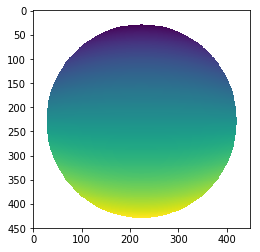

In [23]:
import matplotlib.pyplot as plt
plt.imshow(v)

In [73]:
depth_values_file = "data/chair_view/short_throw_depth (2)/short_throw_depth\\00131957160949186890.pgm"

In [74]:
depth_values = np.fromfile(depth_values_file, dtype = np.float32)

In [75]:
from PIL import Image

(448, 450)


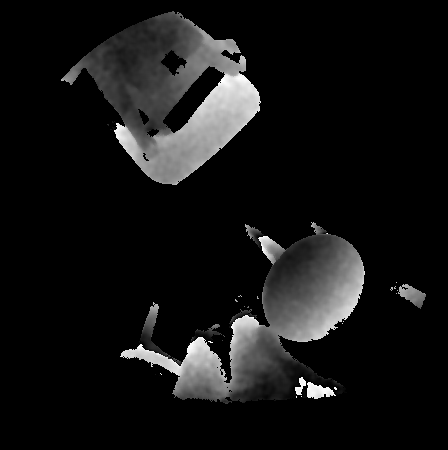

In [76]:
im = Image.open(depth_values_file)
print(im.size) # Height width is swapped from the original case
depth_values = im.load()
im

In [88]:
def get_camera_view_pts(depth_values, u, v):
    output_frame = np.zeros((450, 448))
    unscaled_frame = np.zeros((450, 448))
    for i in range(448):
        for j in range(450):
            if depth_values[i,j] > 64000:
                continue
            output_frame[j][i] = depth_values[i,j]
            unscaled_frame[j][i] = -1.0 * output_frame[j][i] / np.sqrt(u[j][i]**2 + v[j][i]**2 + 1)
    eff_frame = unscaled_frame/1000
    x_pts = u * eff_frame
    y_pts = v * eff_frame
    z_pts = eff_frame
    return np.stack((x_pts.reshape(-1), y_pts.reshape(-1), z_pts.reshape(-1)), axis=1)

In [394]:
# DEPRECATED
# %matplotlib inline
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# xyz = np.stack((xdata,ydata,zdata), axis=1)
# xyz_ones = np.ones((xyz.shape[0], xyz.shape[1]+1))
# xyz_ones[:,:-1]= xyz
# results = np.dot(camera_view_transform_inverse, xyz_ones.T).T
# print(results.shape)
# fig = plt.figure(figsize=(20,20))
# ax = plt.axes(projection='3d')
# ax.scatter3D(xdata, ydata, zdata)
# # ax.scatter3D(results[:,0],results[:,1], results[:,2])
# fig.savefig("test",dpi=420, figsize=(10,10))
# plt.savefig("test3",dpi=420, figsize=(10,10),s=1)

### Following would be the utility for moving to world space. See if different frames align together in this space.

In [148]:
# Read the csv file containing the Transform matrices
csv_path = "data/ball-2/short_throw_depth-3-2.csv"
def get_frame_matrix(csv_path, image_num):
    with open(csv_path, "r") as csv_file:
        header = csv_file.readline()
        for line in csv_file:
            line = line.strip()
            if not line:
                continue
            elems = line.split(",")
            if elems[1].split("\\")[1] == image_num:
                frame_to_origin = np.array(list(map(float, elems[2:18])))
                frame_to_origin = frame_to_origin.reshape(4,4)
                camera_view = np.array(list(map(float, elems[18:34])))
                camera_view = camera_view.reshape(4,4)
                # camera_projection -> camera_view -> world state
                camera_view_to_world = np.dot(frame_to_origin, np.linalg.inv(camera_view))
                return camera_view_to_world

In [149]:
# Map camera view points to world
def map_points_to_world(camera_view_pts, world_matrix):
    """
    Camera View Points will be nx3. Will add a column of 1s to make it nx4.
    """
    camera_view_pts_ones = np.ones((camera_view_pts.shape[0], camera_view_pts.shape[1]+1))
    camera_view_pts_ones[:,:-1]= camera_view_pts
    return np.dot(world_matrix, camera_view_pts_ones.T).T

(448, 450)


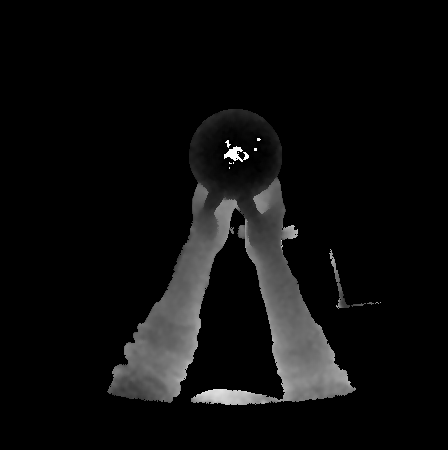

In [150]:
image_number = "00131957199438912227.pgm"
depth_values_file = "data/ball-2/" + image_number
depth_values = np.fromfile(depth_values_file, dtype = np.float32)
im = Image.open(depth_values_file)
print(im.size) # Height width is swapped from the original case
depth_values = im.load()
im

In [151]:
u, v = get_cam_space_projection(projection_bin, image_height, image_width )
camera_view_pts = get_camera_view_pts(depth_values, u, v)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


In [152]:
camera_view_to_world = get_frame_matrix(csv_path, image_number)

In [153]:
world_coordinates = map_points_to_world(camera_view_pts, camera_view_to_world)
world_coordinates_3d = (world_coordinates / world_coordinates[:,-1][:,None])[:,:-1]
np.savetxt("pts/camera_view_coordinates.csv", camera_view_pts, delimiter=",")
np.savetxt("pts/world_coordinates.csv", world_coordinates_3d , delimiter=",")

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [60]:
# This is to generate the room using Long ToF
from os import listdir
import os
from tqdm import tqdm
projection_bin = "data/chair_view/short_throw_depth_camera_space_projection-2.bin"
directory = "data/chair_view/short_throw_depth (2)"
image_height = 450
image_width = 448
u, v = get_cam_space_projection(projection_bin, image_height, image_width )
files = listdir(directory)
pointcloud = []
for i in tqdm(range(0,len(files)-30,30)):
    file = files[i]
    image_number = file.split("\\")[1]
    depth_values_file = os.path.join(directory, file)
    depth_values = np.fromfile(depth_values_file, dtype = np.float32)
    im = Image.open(depth_values_file)
    depth_values = im.load()
    camera_view_pts = get_camera_view_pts(depth_values, u, v)
    camera_view_to_world = get_frame_matrix(csv_path, image_number)
    world_coordinates = map_points_to_world(camera_view_pts, camera_view_to_world)
    world_coordinates_3d = (world_coordinates / world_coordinates[:,-1][:,None])[:,:-1]
    pointcloud.append(world_coordinates_3d)
    break
    


  0%|          | 0/34 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':



In [61]:
world_pts = np.concatenate(pointcloud)
np.savetxt("pts/world_coordinates.csv", world_pts , delimiter=",")

(13104000, 3)